# Scripts 

In [1]:
%run '../shared-code/utils.py' 

# Dependencies

In [2]:
import pandas as pd 
import joblib 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np 
import copy
from sklearn.inspection import permutation_importance

%matplotlib inline 

# Utils 

In [3]:
reverse_mse=lambda x: -1 * x 

def get_ccp_alpha_erros(ccp_alphas,X,y):
    errs={}
    for ccp in ccp_alphas: 
        tree=DecisionTreeRegressor(random_state=42,ccp_alpha=ccp)
        cvs=cross_val_score(
            cv=10,
            scoring=house_pricing_metric,
            estimator=tree,
            X=X,
            y=y,
            n_jobs=-1
        ) 
        errs[ccp]={
            'cvs': cvs,
            'score': np.mean(cvs)
        }
    tmp=pd.DataFrame(errs)
    cvs=pd.DataFrame(
            data=tmp.loc['cvs'].values.tolist(),
            index=tmp.columns
        ).rename(mapper=lambda x: f'cv{x}',axis=1) 
    tmp=pd.concat([
        cvs,
        tmp.loc['score',:],
    ],axis=1)  
    errs=tmp
    return tmp

def param_space_search(tree,X,y,param_grid):
    fine_tuner=GridSearchCV(
        estimator=tree,
        cv=10,
        scoring=house_pricing_metric,
        param_grid=param_grid
    )
    fine_tuner.fit(X,y)
    return fine_tuner 

def plot_cvs(fine_tuner):
    res=pd.DataFrame(fine_tuner.cv_results_)
    axs=res[[f'split{i}_test_score' for i in range(10)]].map(reverse_mse)\
        .plot.kde(subplots=True,layout=(5,2),figsize=(20,20))
    for ax in axs:
        ax=ax[0]
        ax.set_xlim((0,1))
    plt.show()

# Load & Process data 

In [4]:
data_pipe=joblib.load('../pipelines/data_pipeline.pkl')

In [5]:
df_tr=pd.read_csv('../data/train.csv')
df_test=pd.read_csv('../data/test.csv')
X_tr,Y_tr=df_tr.drop([TARGET_COL,'Id',"Index"],axis=1),df_tr[TARGET_COL]
X_test,Y_test=df_test.drop([TARGET_COL,"Id","Index"],axis=1),df_test[TARGET_COL]

In [6]:
data_pipe.fit(X_tr)
X_tr_proc,X_test_proc=data_pipe.transform(X_tr),data_pipe.transform(X_test)

# Tree 

In [10]:
tree=DecisionTreeRegressor() 
cvs=cross_val_score(
    estimator=tree,
    X=X_tr_proc,
    y=Y_tr,
    n_jobs=-1,
    cv=10,
    scoring=house_pricing_metric
)
-1 * np.mean(cvs)

0.20358998192723538

## Pre processing prunning 

Ke se obidime da najdeme dobra konfiguracija za max_depth, min_samples_leaf. Ovie 2 parametri ke ni se najdobri za regression problem, bidejki min_samples_leaf osigurat deka ke imat dovolno samples vo leaf za odluka, dodeka max_depth ke osigurat deka nemat preterano da splitvime. Max_depth nekako ne me bendisvit deka mozda nekoj cases ke mu trebat pojke splitvenje, no sepak ke se postignit generazliacija. Spored to ednash ke probame samo so min_samples_leaf, ednash so 2te zaedno. 

In [11]:
tree=DecisionTreeRegressor(random_state=42) 
param_space_min_samples=np.linspace(start=0.01,stop=0.8,num=50)
fine_tuner_min_samples_leaf=GridSearchCV(
    estimator=tree,
    cv=10,
    scoring=house_pricing_metric,
    param_grid={
        "min_samples_leaf": param_space_min_samples 
    }
)
fine_tuner_min_samples_leaf.fit(X_tr_proc,Y_tr)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'min_samples_leaf': array([0.01      , 0.02612245, 0.0422449 , 0.05836735, 0.0744898 ,
       0.09061224, 0.10673469, 0.12285714, 0.13897959, 0.15510204,
       0.17122449, 0.18734694, 0.20346939, 0.21959184, 0.23571429,
       0.25183673, 0.26795918, 0.28408163, 0.30020408, 0.31632653,
       0.33244898, 0.34857143, 0.36469388, 0.38081633, 0.39693878,
       0.41306122, 0.42918367, 0.44530612, 0.46142857, 0.47755102,
       0.49367347, 0.50979592, 0.52591837, 0.54204082, 0.55816327,
       0.57428571, 0.59040816, 0.60653061, 0.62265306, 0.63877551,
       0.65489796, 0.67102041, 0.68714286, 0.70326531, 0.71938776,
       0.7355102 , 0.75163265, 0.7677551 , 0.78387755, 0.8       ])},
             scoring=make_scorer(rmse_logs, response_method='predict'))

In [13]:
"Best score with pre prunning, only min_samples_leaf {}"\
    .format(-1 * fine_tuner_min_samples_leaf.best_score_)

'Best score with pre prunning, only min_samples_leaf 0.18849921886580723'

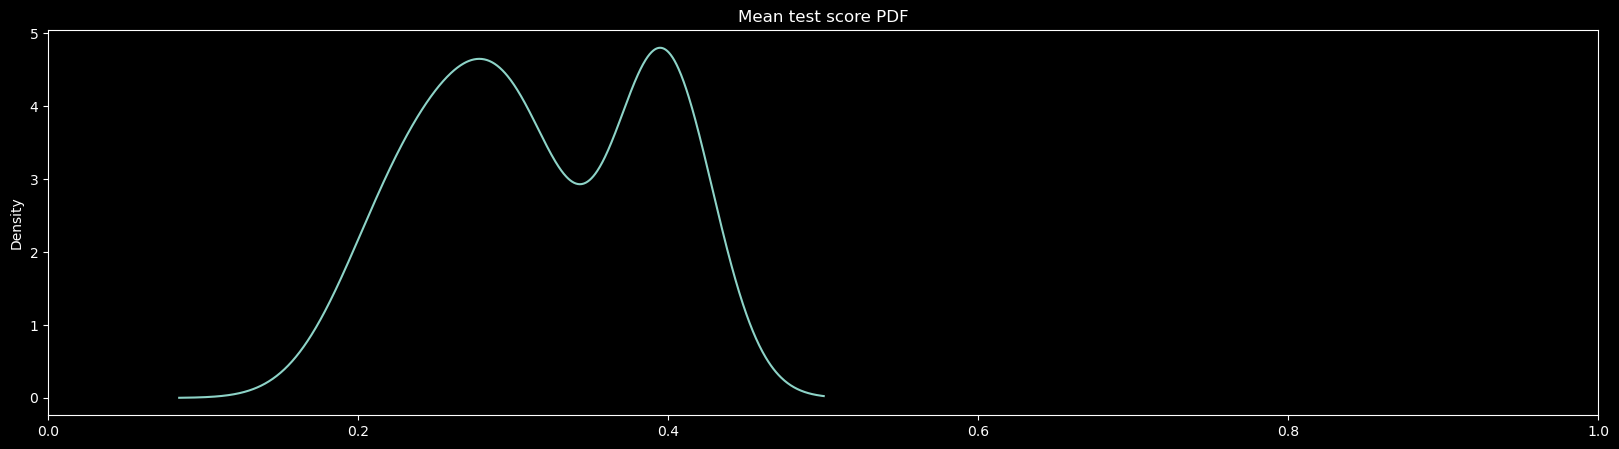

In [14]:
res=pd.DataFrame(fine_tuner_min_samples_leaf.cv_results_)
ax=res['mean_test_score'].map(reverse_mse).plot.kde(title='Mean test score PDF',figsize=(20,5))
ax.set_xlim((0,1))
plt.show()

Znachit najcesto modelive imat preformansi vo (0.2,0.3) i (0.35,0.45)

Da vidime dali nekoj subset na data e biten za trainingot. To znachit dali kaj site dataset generalno imat ista distribucija na preformansi ili pak nekade e mnogu porazlichno, sho bi indiciralo deka train datasetot e dosta povolen za modelot vo takov slucaj. 

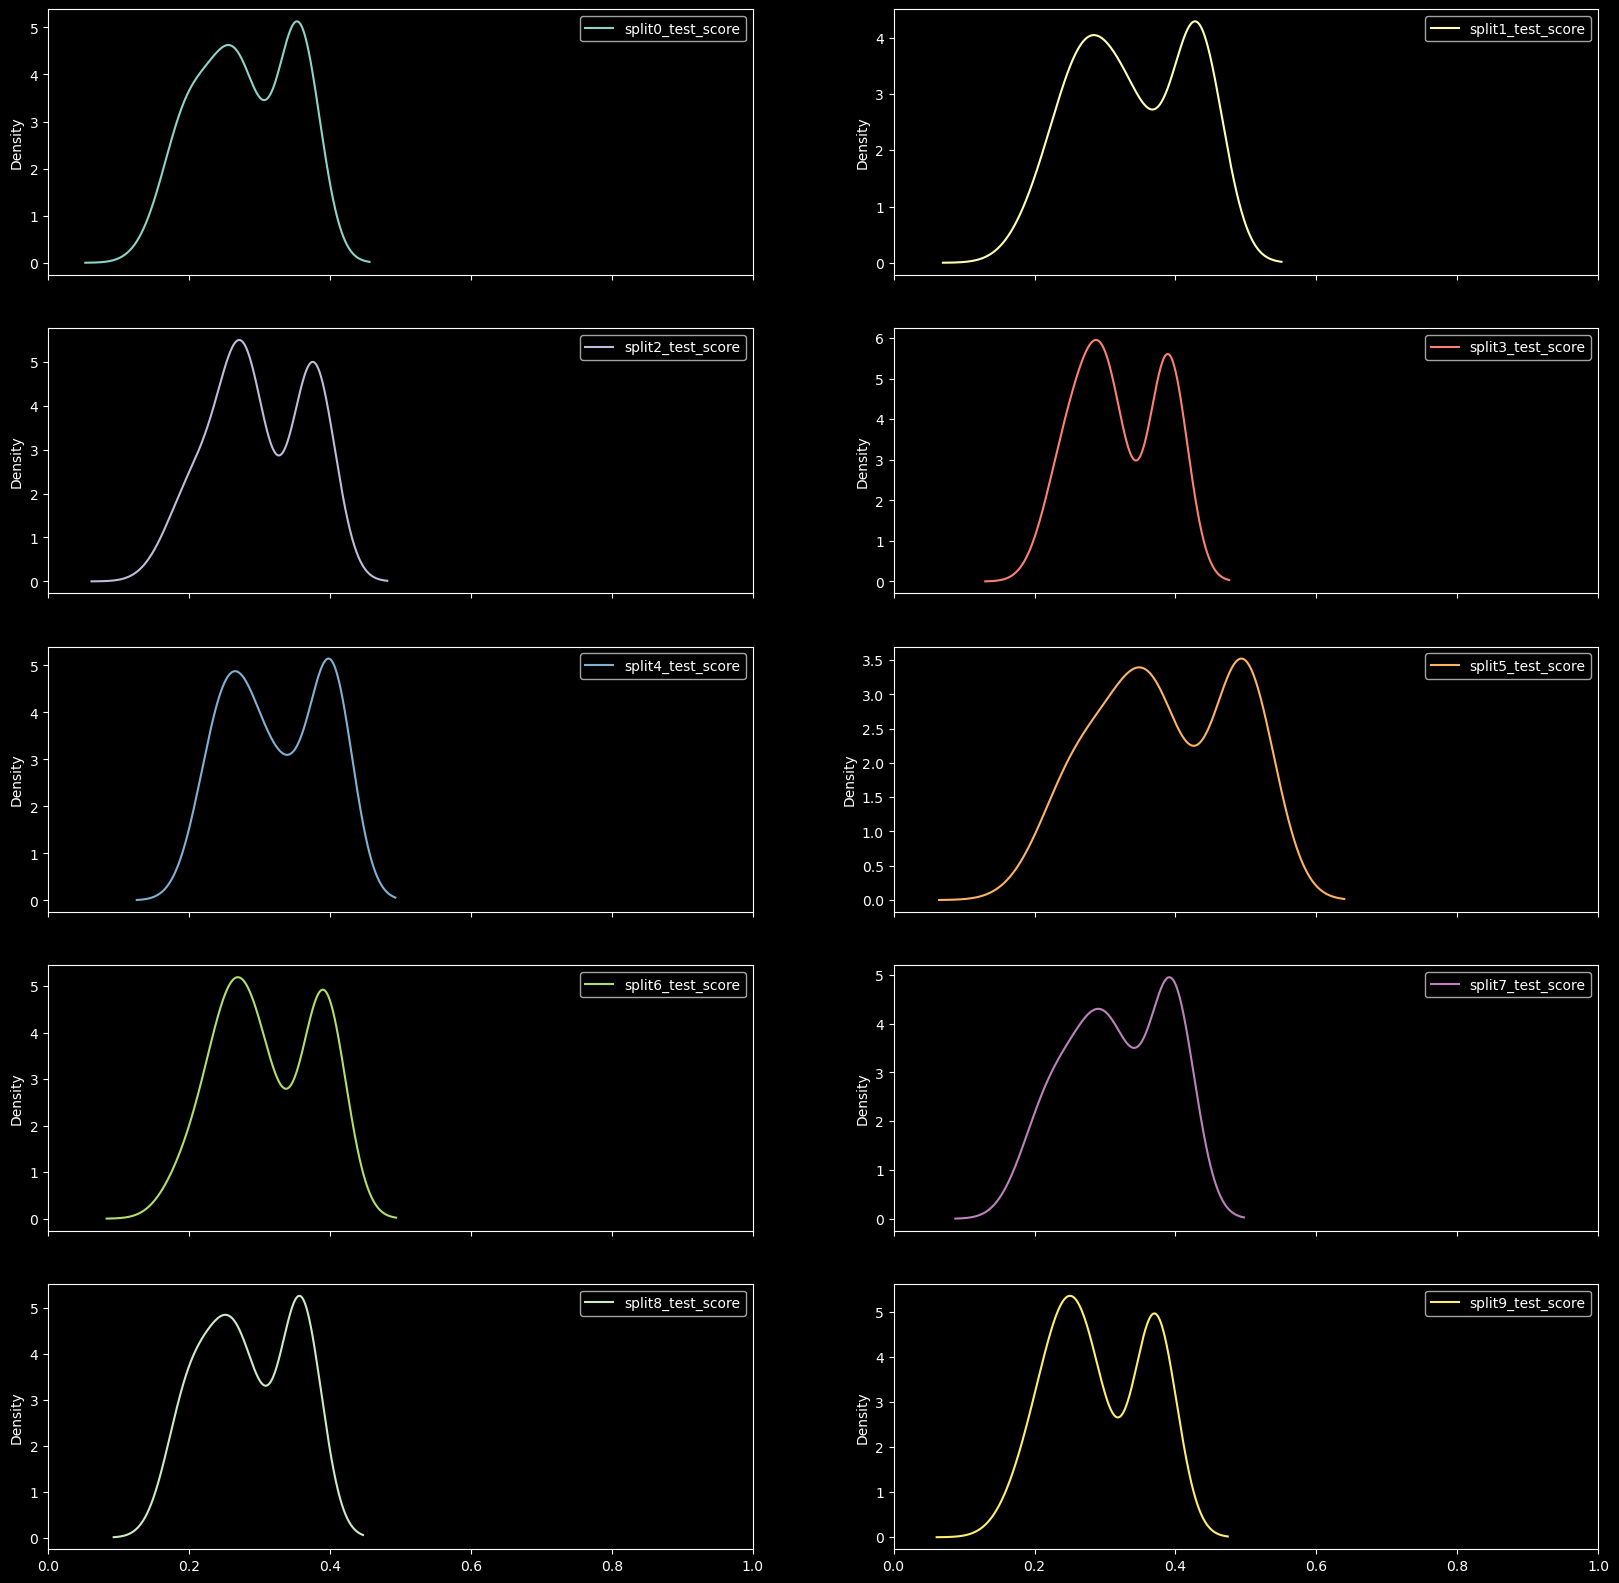

In [15]:
plot_cvs(fine_tuner=fine_tuner_min_samples_leaf)

Spored distribucijata ne gledame nekoja prefrenca vo odnos na subset of datasetot. 

In [16]:
tree = DecisionTreeRegressor(random_state=42)
param_space_min_samples = np.linspace(start=0.00001, stop=1,num=80)
param_space_max_depth =np.linspace(
    start=int(0.1*X_tr_proc.shape[1]),
    stop=int(1.2*X_tr_proc.shape[1]),
    dtype=np.int64
) 
fine_tuner_all = GridSearchCV(
    estimator=tree,
    scoring=house_pricing_metric,
    cv=10,
    param_grid={
        "min_samples_leaf": param_space_min_samples,
        "max_depth": param_space_max_depth,
    },
    n_jobs=-1,
)
fine_tuner_all.fit(X_tr_proc, Y_tr)

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
500 fits failed out of a total of 40000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_p

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([ 7,  8, 10, 12, 13, 15, 17, 19, 20, 22, 24, 26, 27, 29, 31, 33, 34,
       36, 38, 39, 41, 43, 45, 46, 48, 50, 52, 53, 55, 57, 59, 60, 62, 64,
       65, 67, 69, 71, 72, 74, 76, 78, 79, 81, 83, 85, 86, 88, 90, 92]),
                         'min_samples_leaf': array([1.00000000e-05, 1.26681013e-02, 2.53262025e-02, 3.79843038e-02,
       5.064...
       7.59496076e-01, 7.72154177e-01, 7.84812278e-01, 7.97470380e-01,
       8.10128481e-01, 8.22786582e-01, 8.35444684e-01, 8.48102785e-01,
       8.60760886e-01, 8.73418987e-01, 8.86077089e-01, 8.98735190e-01,
       9.11393291e-01, 9.24051392e-01, 9.36709494e-01, 9.49367595e-01,
       9.62025696e-01, 9.74683797e-01, 9.87341899e-01, 1.00000000e+00])},
             scoring=make_scorer(rmse_logs, response_method='predict'))

In [17]:
'Best score with pre prunning {}'.format(-1 * fine_tuner_all.best_score_)

'Best score with pre prunning 0.18682882416987295'

In [21]:
best_tree=fine_tuner_all.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.012668101265822785,
                      random_state=42)

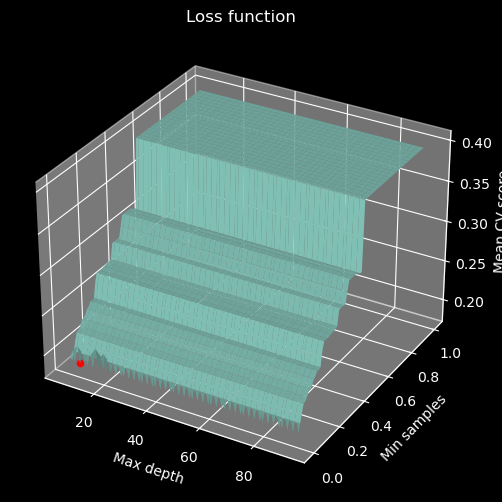

In [22]:
results=pd.DataFrame(fine_tuner_all.cv_results_)
results=pd.concat([
    results[['params','mean_test_score']]['params'].apply(pd.Series),
    results['mean_test_score'].apply(reverse_mse)
],axis=1)

max_depth_gird,min_samples_grid=np.meshgrid(param_space_max_depth,param_space_min_samples)
col_size=param_space_min_samples.shape[0]
row_size=param_space_max_depth.shape[0]
vals=results['mean_test_score'].values 

cv_scores=np.array([[vals[i*col_size + j] for j in range(col_size)]
           for i in range(row_size)]).T 

plt.figure(figsize=(20,6))
ax=plt.axes(projection='3d')
ax.plot_surface(max_depth_gird,min_samples_grid,cv_scores)

ax.set_title("Loss function")
ax.set_xlabel("Max depth")
ax.set_ylabel("Min samples")
ax.set_zlabel("Mean CV score")


ax.scatter3D(
    fine_tuner_all.best_params_['max_depth'],
    fine_tuner_all.best_params_['min_samples_leaf'],
    -1 * fine_tuner_all.best_score_,
    c='r'
)
plt.show() 

Bidejki nemozhit min_samples < 0, sigurni sme deka dovolno dobro go fine tuniravme modelot. 

## Post processing prunning

In [23]:
tree=DecisionTreeRegressor(random_state=42) 
ccp_alphas = tree.cost_complexity_pruning_path(X_tr_proc,Y_tr).ccp_alphas
ccp_alphas

array([0.00000000e+00, 9.63184932e-02, 3.86344178e+00, ...,
       3.17833816e+08, 6.69215302e+08, 2.72237145e+09])

In [26]:
errs=get_ccp_alpha_erros(ccp_alphas,X_tr_proc,Y_tr)
errs

,cv0,cv1,cv2,cv3,cv4,cv5,cv6,cv7,cv8,cv9,score
0.000000e+00,-0.186937,-0.199138,-0.194477,-0.217584,-0.194860,-0.228405,-0.229798,-0.192917,-0.184083,-0.184953,-0.201315
9.631849e-02,-0.186937,-0.199138,-0.194477,-0.217584,-0.194860,-0.228405,-0.229798,-0.192917,-0.184083,-0.184953,-0.201315
3.863442e+00,-0.186937,-0.199138,-0.194477,-0.217584,-0.194860,-0.228405,-0.229798,-0.192917,-0.184082,-0.184955,-0.201315
4.280822e+00,-0.186937,-0.199138,-0.194477,-0.217584,-0.194860,-0.228405,-0.229798,-0.192917,-0.184082,-0.184955,-0.201315
5.707763e+00,-0.186932,-0.199136,-0.194475,-0.217587,-0.194861,-0.228405,-0.229798,-0.192913,-0.184082,-0.184957,-0.201315
...,...,...,...,...,...,...,...,...,...,...,...
1.697280e+08,-0.207339,-0.267039,-0.229479,-0.261881,-0.272478,-0.311484,-0.252632,-0.242953,-0.221843,-0.246593,-0.251372
2.501591e+08,-0.236990,-0.276846,-0.229727,-0.287539,-0.286314,-0.351023,-0.260746,-0.270340,-0.222462,-0.249854,-0.267184
3.178338e+08,-0.236990,-0.285052,-0.244721,-0.287539,-0.286733,-0.351023,-0.276733,-0.270340,-0.242010,-0.249854,-0.273099
6.692153e+08,-0.241920,-0.331372,-0.250087,-0.285296,-0.342092,-0.392765,-0.321561,-0.270429,-0.284540,-0.281946,-0.300201


In [27]:
'Best score with post prunning {}'.format(errs['score'].apply(lambda x: -1*x).min()) 

'Best score with post prunning 0.1919360961722023'

Generalno pre prunningot e podobar.

## PCA 

## Standardizing features before PCA 

In [28]:
pipe_PCA=copy.deepcopy(data_pipe)
pipe_PCA.steps.append(("Standardization",StandardScaler()))
pipe_PCA.steps.append(("PCA",PCA()))

In [29]:
pipe_PCA.fit(X_tr,Y_tr)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x73abc00bd000>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
                                                   'Foundation', 'Heating',
                                                   'CentralAir', 'Electrical',
                                                   'GarageType', 'MiscFeature',
                                                   'SaleType', 'SaleCondition',
                                                   'MasVnrType'])])),
                ('functiontransformer-4',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x73abb87d9ea0>)),
                ('functiontransformer-5',
                 FunctionTransformer(func=<function conv_npfloat64 at 0x73abbf3ae710>)),
                ('Standardization', StandardScaler()), ('PCA', PCA())])

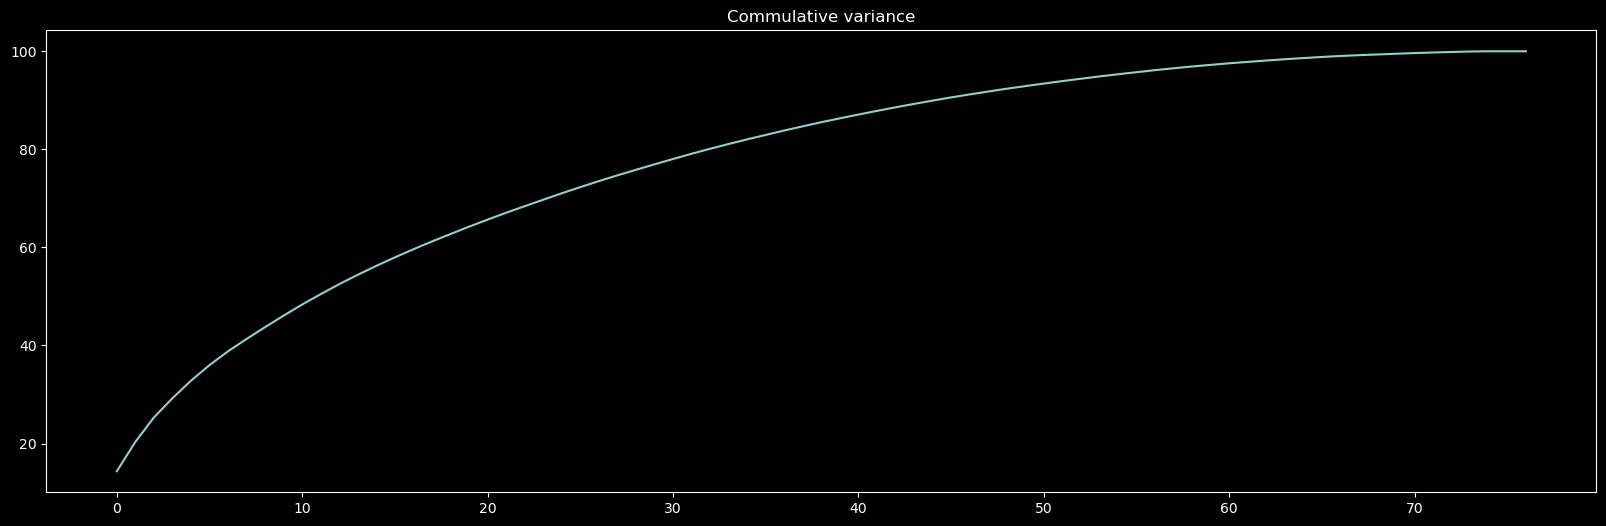

In [30]:
pca=pipe_PCA.steps[-1][1]
plt.figure(figsize=(20,6))
plt.title("Commulative variance")
sns.lineplot(
    x=list(range(pca.explained_variance_ratio_.shape[0])),
    y=(pca.explained_variance_ratio_*100).cumsum(),
) 
plt.show() 

In [33]:
var_expl=pd.Series(data=(pca.explained_variance_ratio_*100).cumsum())
n_components=var_expl[var_expl>=95].index.values[0]
n_components

54

Odbirame components barem 95% variance da objasnat. 

In [34]:
pipe_PCA.steps[-1]=("PCA",PCA(n_components=n_components))
pipe_PCA.fit(X_tr,Y_tr)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x73abc00bd000>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
                                                   'CentralAir', 'Electrical',
                                                   'GarageType', 'MiscFeature',
                                                   'SaleType', 'SaleCondition',
                                                   'MasVnrType'])])),
                ('functiontransformer-4',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x73abb87d9ea0>)),
                ('functiontransformer-5',
                 FunctionTransformer(func=<function conv_npfloat64 at 0x73abbf3ae710>)),
                ('Standardization', StandardScaler()),
                ('PCA', PCA(n_components=54))])

In [35]:
X_tr_PCA,X_test_PCA=pipe_PCA.transform(X_tr),\
    pipe_PCA.transform(X_test)

In [36]:
tree=DecisionTreeRegressor(random_state=42) 
cvs=cross_val_score(
    n_jobs=-1,
    estimator=tree,
    cv=10,
    scoring=house_pricing_metric,
    X=X_tr_PCA,
    y=Y_tr
)
'Best score Tree with PCA {}'.format(-1 * np.mean(cvs)) 

'Best score Tree with PCA 0.21998532070043644'

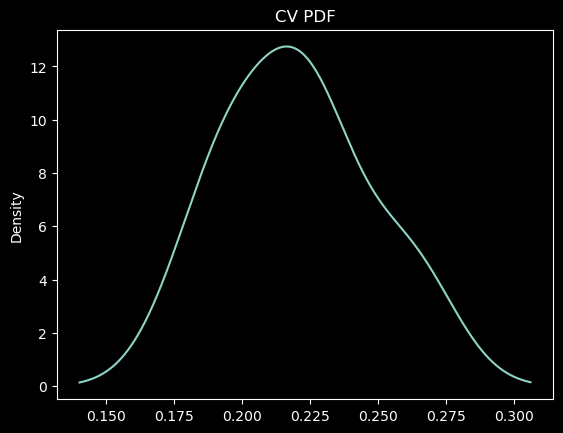

In [37]:
(pd.Series(cvs)* -1).plot.kde(title='CV PDF')
plt.show()

Bidejki zemavme cross validation mozhit golemata greshka da se dolzhit na hyperparametrite, zaradi toa ke podistrazhime. Najprvin ke zapochnime so post path prunning. 

In [38]:
tree=DecisionTreeRegressor(random_state=42) 
tree.fit(X_tr_PCA,Y_tr)
errs=get_ccp_alpha_erros(
    ccp_alphas=tree.cost_complexity_pruning_path(X_tr_PCA,Y_tr).ccp_alphas,
    X=X_tr_PCA,
    y=Y_tr
)
errs

,cv0,cv1,cv2,cv3,cv4,cv5,cv6,cv7,cv8,cv9,score
0.000000e+00,-0.202886,-0.227883,-0.200308,-0.222285,-0.257414,-0.264706,-0.225049,-0.181705,-0.192289,-0.225327,-0.219985
1.070205e+00,-0.202886,-0.227883,-0.200308,-0.222285,-0.257414,-0.264706,-0.225049,-0.181705,-0.192289,-0.225327,-0.219985
1.605308e+00,-0.202886,-0.227883,-0.200308,-0.222285,-0.257414,-0.264708,-0.225049,-0.181704,-0.192289,-0.225327,-0.219985
1.979452e+00,-0.202886,-0.227883,-0.200308,-0.222285,-0.257414,-0.264708,-0.225049,-0.181704,-0.192289,-0.225327,-0.219985
2.344178e+00,-0.202886,-0.227883,-0.200306,-0.222285,-0.257414,-0.264708,-0.225049,-0.181704,-0.192289,-0.225327,-0.219985
...,...,...,...,...,...,...,...,...,...,...,...
1.107435e+08,-0.142121,-0.192316,-0.170524,-0.199434,-0.190945,-0.245214,-0.182526,-0.170965,-0.185993,-0.182832,-0.186287
1.665056e+08,-0.142818,-0.227599,-0.201492,-0.200841,-0.190739,-0.293636,-0.182586,-0.204849,-0.186351,-0.187068,-0.201798
4.996551e+08,-0.169280,-0.247419,-0.201492,-0.235836,-0.227708,-0.293636,-0.228669,-0.204849,-0.203421,-0.202737,-0.221505
8.039263e+08,-0.176212,-0.324792,-0.209649,-0.239081,-0.301067,-0.370132,-0.228669,-0.294333,-0.210817,-0.270540,-0.262529


In [39]:
'Best score with PCA and post prunning {}'.format(errs['score'].max() * -1)

'Best score with PCA and post prunning 0.18010881903989023'

In [40]:
param_space_min_samples = np.linspace(start=0.00001, stop=1,num=80)
param_space_max_depth =np.linspace(
    start=int(0.1*X_tr_proc.shape[1]),
    stop=int(1.2*X_tr_proc.shape[1]),
    dtype=np.int64
) 
fine_tuner_all = GridSearchCV(
    estimator=tree,
    scoring=house_pricing_metric,
    cv=10,
    param_grid={
        "min_samples_leaf": param_space_min_samples,
        "max_depth": param_space_max_depth,
    },
    n_jobs=-1,
)
fine_tuner_all.fit(X_tr_PCA,Y_tr)

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
500 fits failed out of a total of 40000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_p

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([ 7,  8, 10, 12, 13, 15, 17, 19, 20, 22, 24, 26, 27, 29, 31, 33, 34,
       36, 38, 39, 41, 43, 45, 46, 48, 50, 52, 53, 55, 57, 59, 60, 62, 64,
       65, 67, 69, 71, 72, 74, 76, 78, 79, 81, 83, 85, 86, 88, 90, 92]),
                         'min_samples_leaf': array([1.00000000e-05, 1.26681013e-02, 2.53262025e-02, 3.79843038e-02,
       5.064...
       7.59496076e-01, 7.72154177e-01, 7.84812278e-01, 7.97470380e-01,
       8.10128481e-01, 8.22786582e-01, 8.35444684e-01, 8.48102785e-01,
       8.60760886e-01, 8.73418987e-01, 8.86077089e-01, 8.98735190e-01,
       9.11393291e-01, 9.24051392e-01, 9.36709494e-01, 9.49367595e-01,
       9.62025696e-01, 9.74683797e-01, 9.87341899e-01, 1.00000000e+00])},
             scoring=make_scorer(rmse_logs, response_method='predict'))

In [41]:
'Best score with PCA and pre prunning {}'.format(-1 * fine_tuner_all.best_score_)

'Best score with PCA and pre prunning 0.1659410304319637'

## Testing on the test dataset

Od modelite sho gi razgledavme ke odberime najdobriot da go probame na test datata. 

In [42]:
pipe_best_model = copy.deepcopy(pipe_PCA)
pipe_best_model.steps.append(
    ("Best model",DecisionTreeRegressor(
        max_depth=7, min_samples_leaf=0.03798430379746836, random_state=42
    ))
)
pipe_best_model.fit(X_tr,Y_tr)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x73abc00bd000>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
                ('functiontransformer-4',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x73abb82379d0>)),
                ('functiontransformer-5',
                 FunctionTransformer(func=<function conv_npfloat64 at 0x73abbf3ae710>)),
                ('Standardization', StandardScaler()),
                ('PCA', PCA(n_components=54)),
                ('Best model',
                 DecisionTreeRegressor(max_depth=7,
                                       min_samples_leaf=0.03798430379746836,
                                       random_state=42))])

In [43]:
"Test score for PCA DecisionTreeRegressor {}".format(-1 * rmse_logs(
    Y_test,
    pipe_best_model.predict(X_test)
))

'Test score for PCA DecisionTreeRegressor 0.17543518832929625'

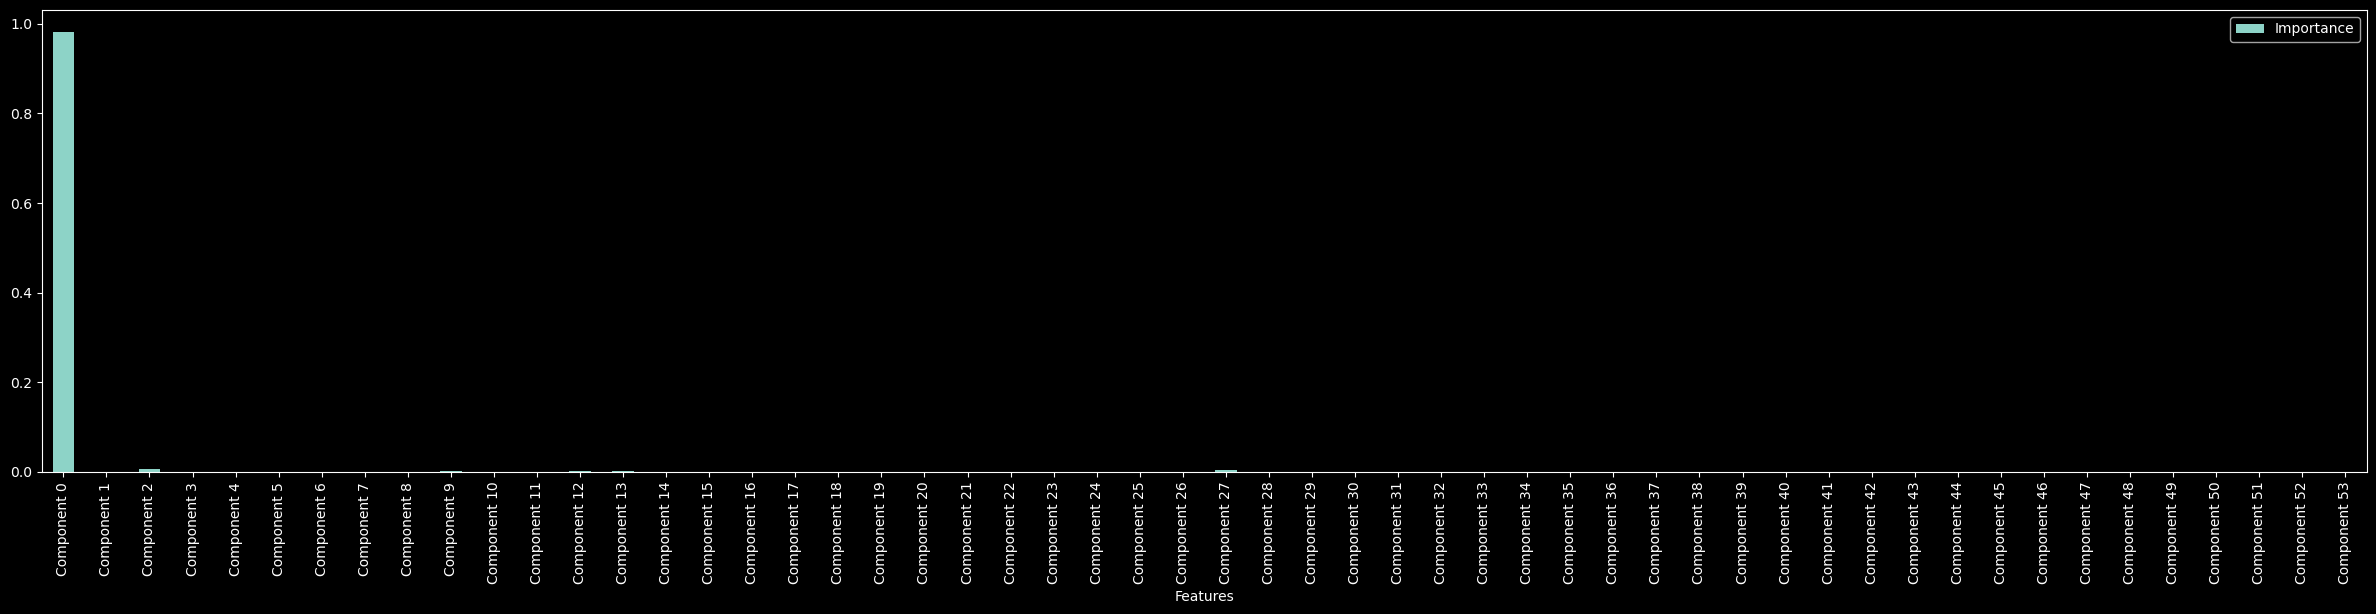

In [44]:
pd.DataFrame(
    data={
        'Importance': pipe_best_model.steps[-1][1].feature_importances_,
        'Features' : [f'Component {i}' for i in range(n_components)] 
    }  
).plot.bar(y='Importance',x='Features',figsize=(30,6))
plt.show()

Imat smisla zoshto prviot component najmnogu tezhina nosit. Prviot components sekogash objasvit najmnogu varijansa.

# Random forest

Najprvin, kako i vo DecisionTreeRegressor, ke zapochnime so searchanje na min_samples_leaf.

In [45]:
tree=RandomForestRegressor(random_state=42,n_jobs=-1) 
param_space_min_samples=np.linspace(start=0.01,stop=0.8,num=10)
param_space_num_estiamtors=np.logspace(start=1,stop=2,base=10,dtype=np.int64,num=10)
fine_tuner=param_space_search(
    tree=tree,
    X=X_tr_proc,
    y=Y_tr,
    param_grid={
        'min_samples_leaf':param_space_min_samples,
        'n_estimators' : param_space_num_estiamtors
    }
)
fine_tuner.best_estimator_

RandomForestRegressor(min_samples_leaf=0.01, n_jobs=-1, random_state=42)

In [46]:
'Ranom forest best score {}'.format(-1 * fine_tuner.best_score_)

'Ranom forest best score 0.15560637665117852'

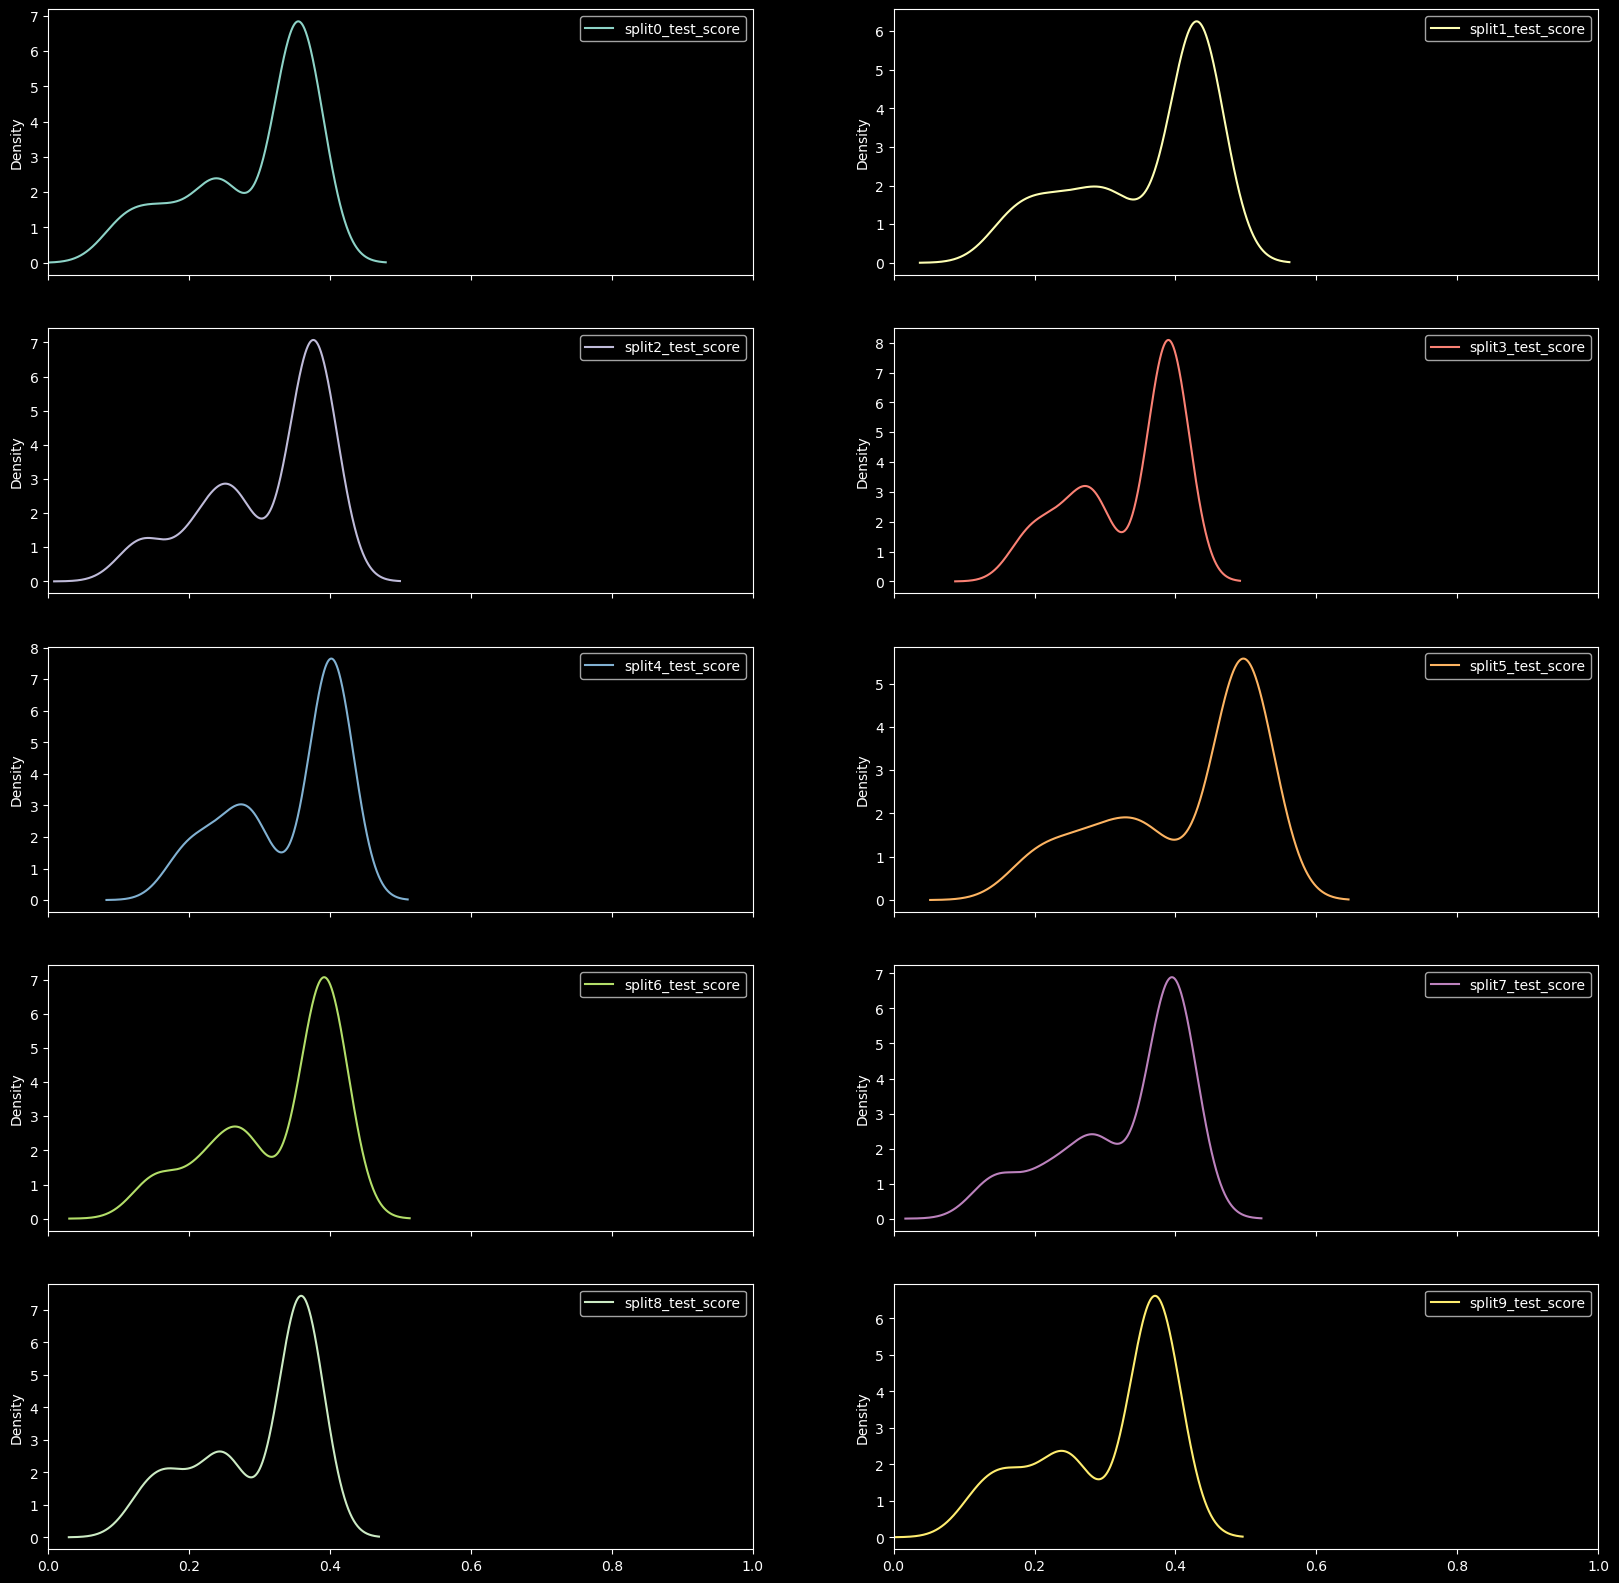

In [47]:
plot_cvs(fine_tuner=fine_tuner)

Generalno imat slichan distribcija, znachit deka site subset imat isto znacenje na modelot.

In [48]:
param_space_min_samples=np.linspace(start=0.01,stop=0.8,num=5)
param_space_num_estiamtors=np.logspace(start=1,stop=2,base=10,dtype=np.int64,num=5)
param_space_max_depth =np.linspace(
    start=int(0.1*X_tr_proc.shape[1]),
    stop=int(1.2*X_tr_proc.shape[1]),
    dtype=np.int64,
    num=5
) 
tree=RandomForestRegressor(random_state=42,n_jobs=-1) 
fine_tuner=param_space_search(
    tree=tree,
    X=X_tr_proc,
    y=Y_tr,
    param_grid={
        'min_samples_leaf':param_space_min_samples,
        'n_estimators' : param_space_num_estiamtors,
        "max_depth" : param_space_max_depth
    }
)
fine_tuner.best_estimator_

RandomForestRegressor(max_depth=49, min_samples_leaf=0.01, n_jobs=-1,
                      random_state=42)

In [49]:
'Best forest with max_depth included {}'.format(-1 *fine_tuner.best_score_)

'Best forest with max_depth included 0.15560637665117852'

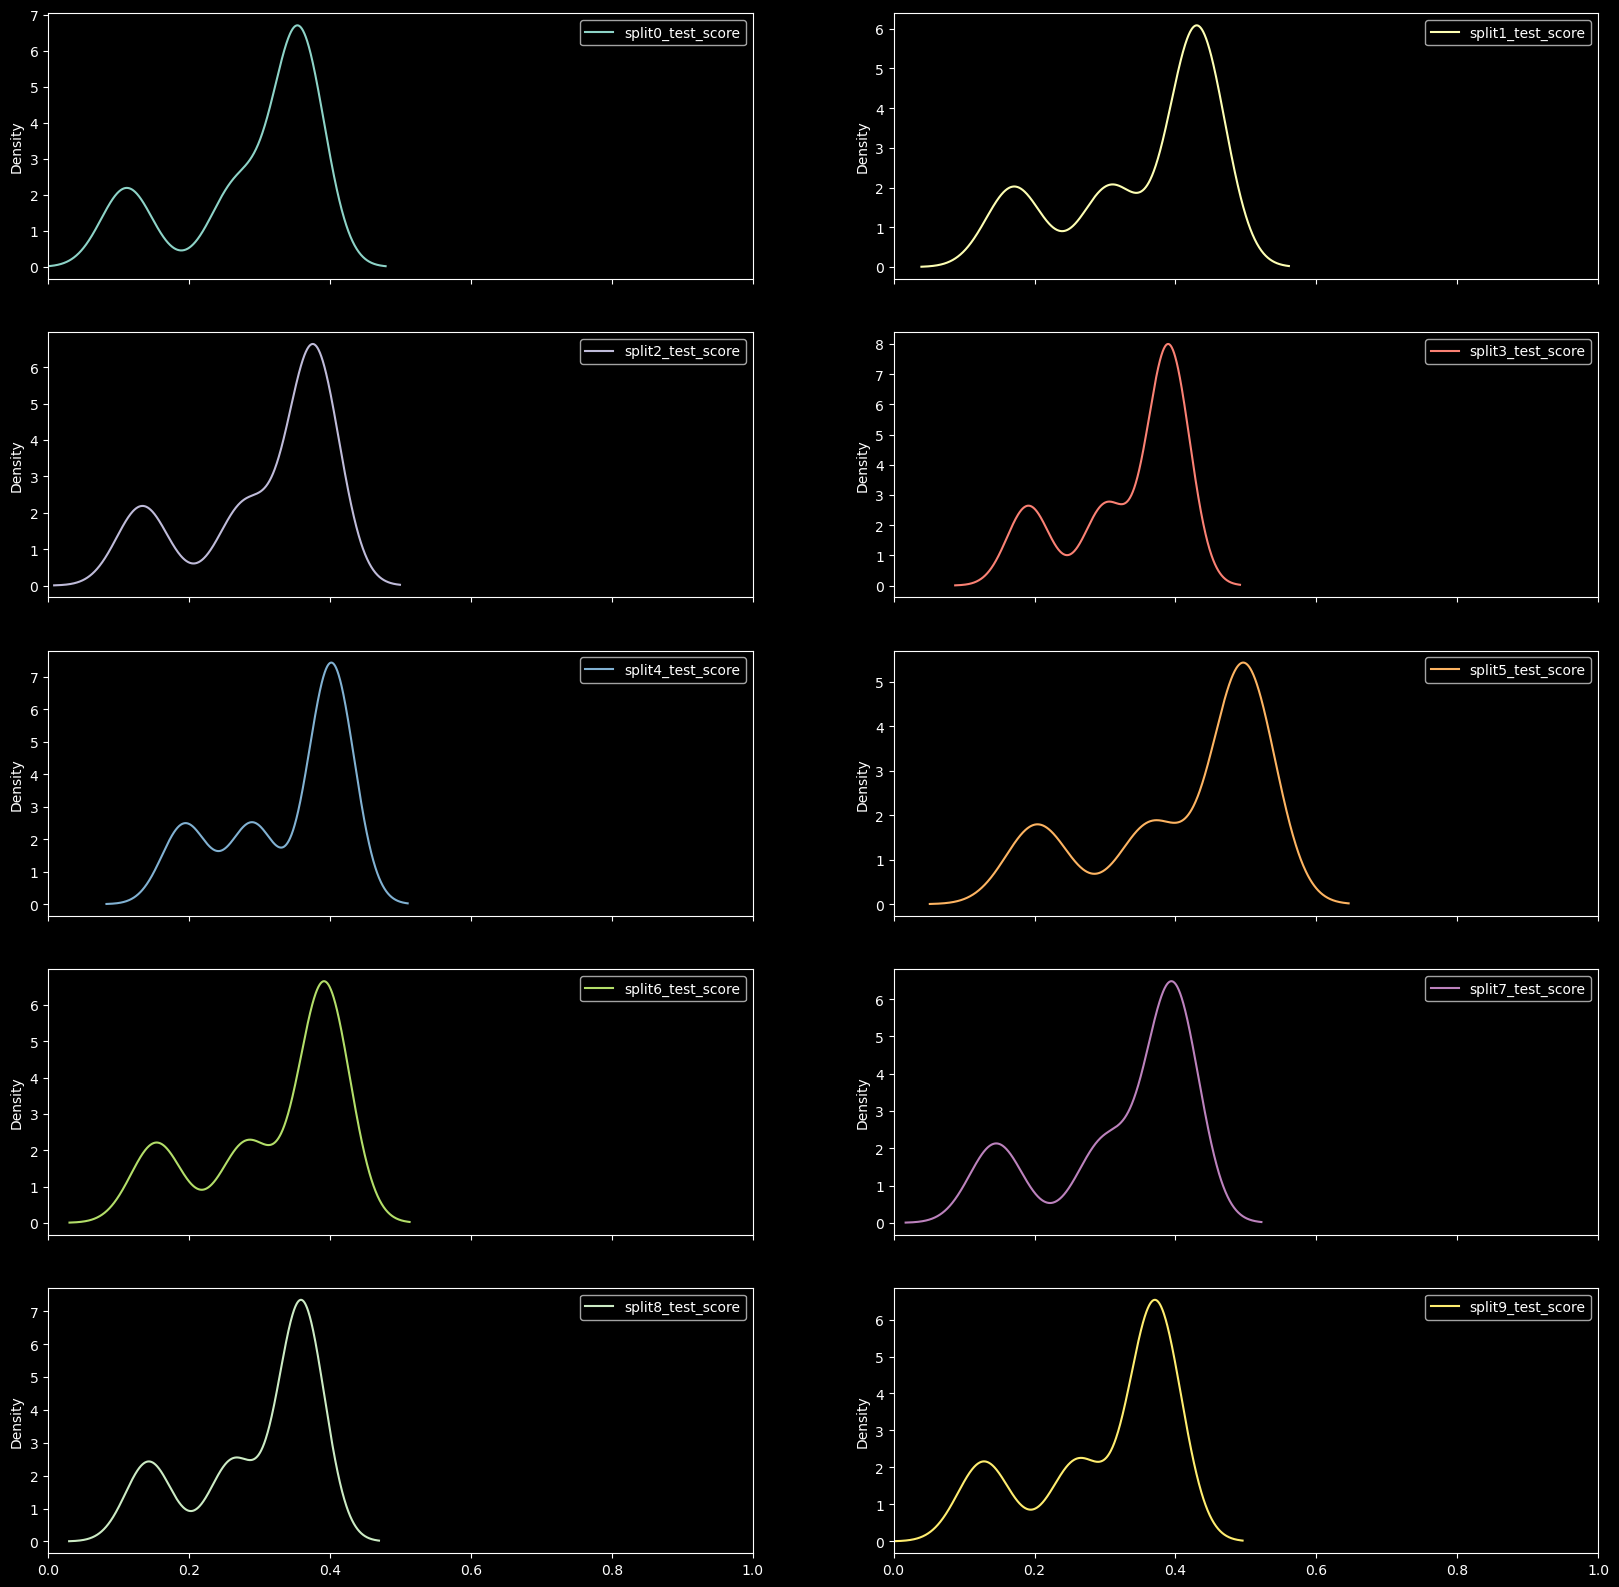

In [50]:
plot_cvs(fine_tuner)

Isto i tuka nemat nekoja varijansa vo treniranjeto. 

## PCA 

Bidejki RandomForest davat podobri rezultati so max_depth, ke go isprobame samo nego.  

In [51]:
param_space_min_samples=np.linspace(start=0.01,stop=0.8,num=5)
param_space_num_estiamtors=np.logspace(start=1,stop=2,base=10,dtype=np.int64,num=5)
param_space_max_depth =np.linspace(
    start=int(0.1*X_tr_proc.shape[1]),
    stop=int(1.2*X_tr_proc.shape[1]),
    dtype=np.int64,
    num=5
) 
tree=RandomForestRegressor(random_state=42,n_jobs=-1) 
fine_tuner=param_space_search(
    tree=tree,
    X=X_tr_PCA,
    y=Y_tr,
    param_grid={
        'min_samples_leaf':param_space_min_samples,
        'n_estimators' : param_space_num_estiamtors,
        "max_depth" : param_space_max_depth
    }
)
fine_tuner.best_estimator_

RandomForestRegressor(max_depth=28, min_samples_leaf=0.01, n_estimators=31,
                      n_jobs=-1, random_state=42)

In [52]:
"Best score with PCA {}".format(-1 * fine_tuner.best_score_)

'Best score with PCA 0.14880412806153512'

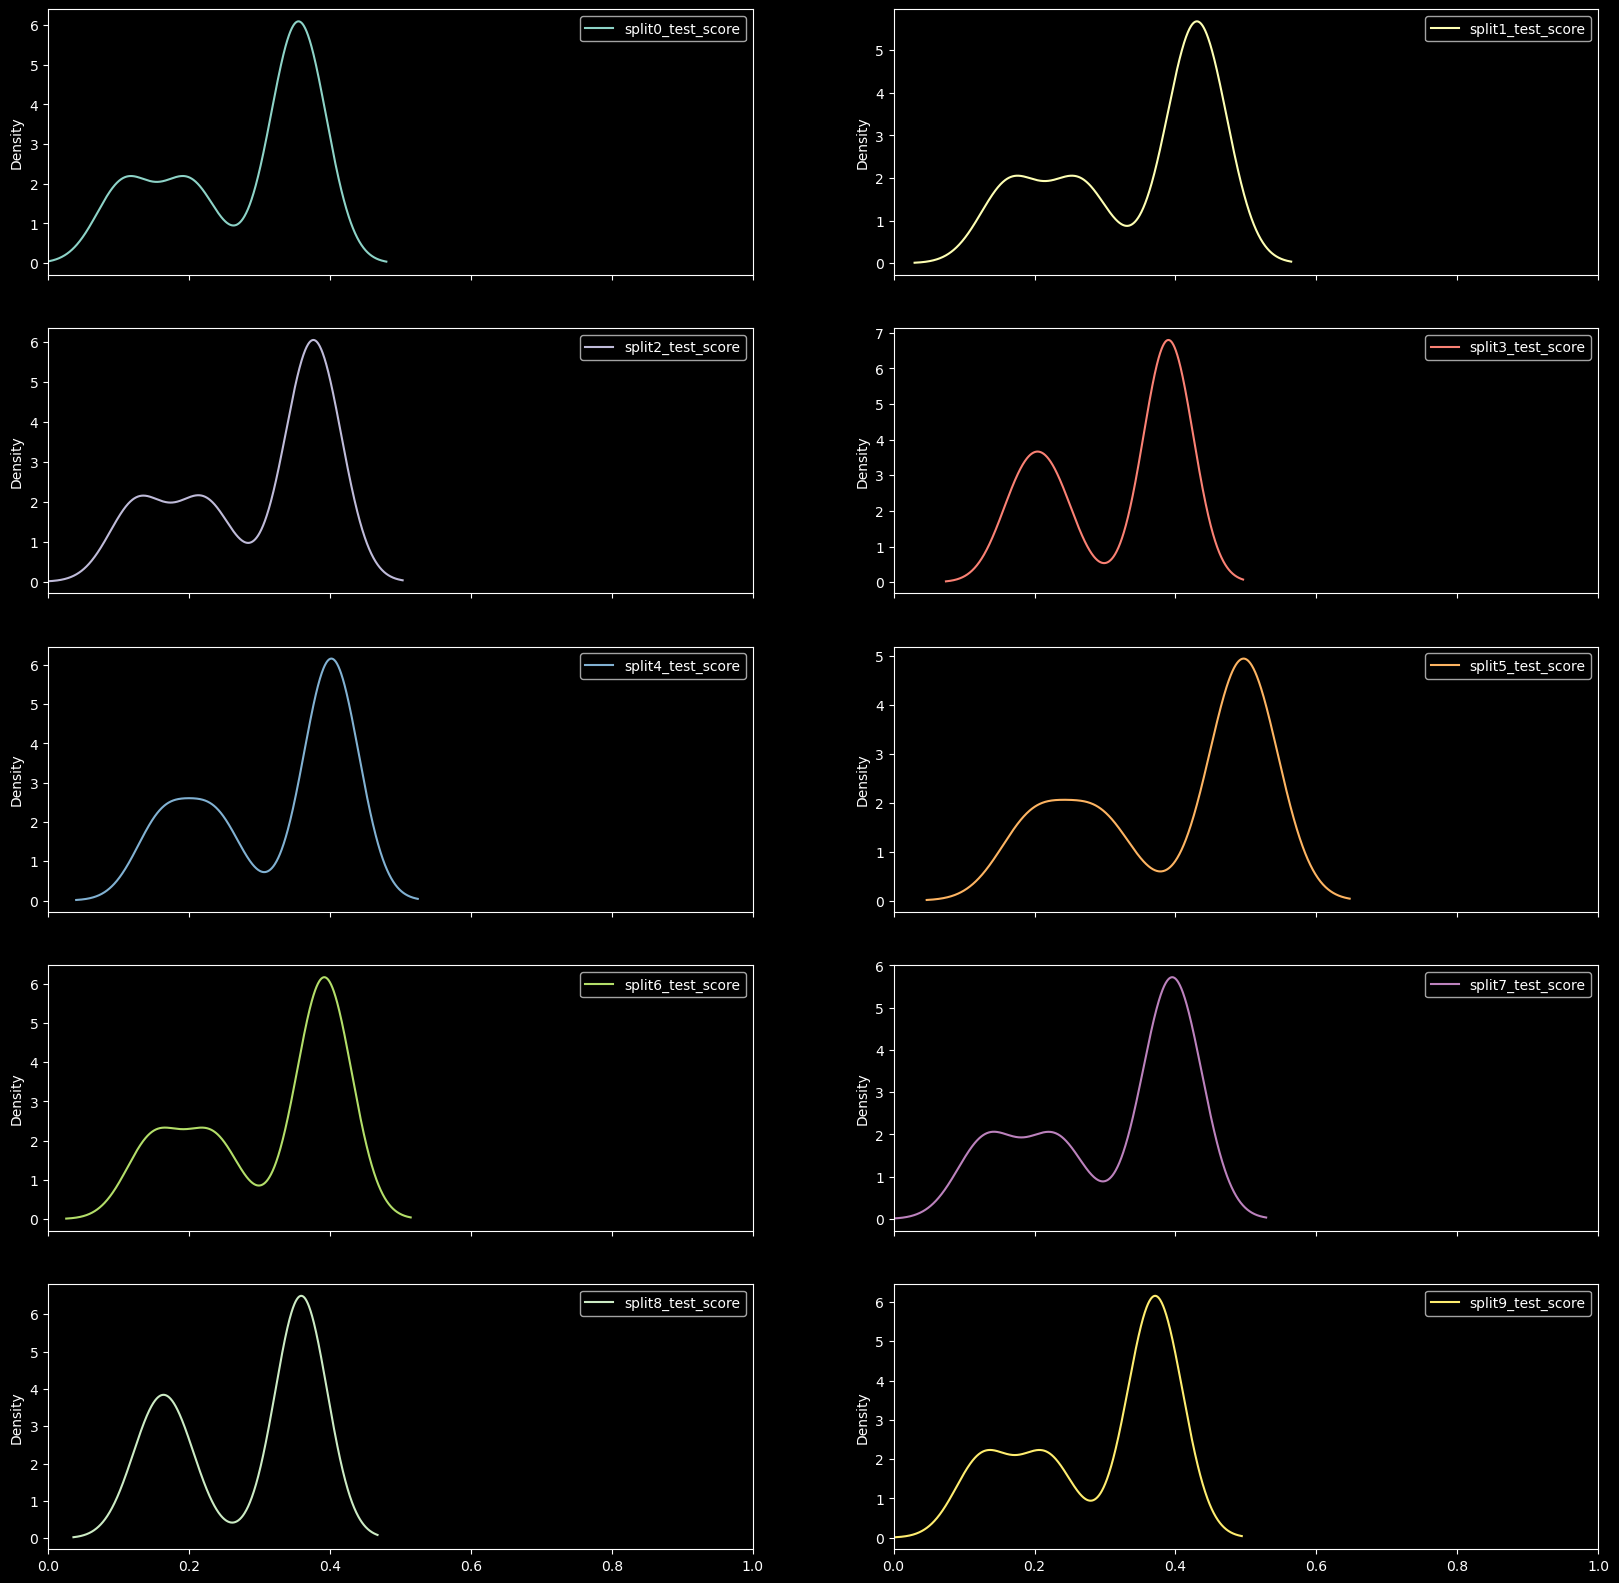

In [53]:
plot_cvs(fine_tuner)

Isto i tuka nemat nekoja varijansa vo treniranjeto. 

## Testing on test dataset

Spored gorenavedenite eksperimenti najdobar model e random forest so max_depth i PCA.  

In [54]:
best_forest_pipe = copy.deepcopy(pipe_PCA)
best_forest_pipe.steps.append(
    (
        "Model",
        RandomForestRegressor(
            max_depth=28,
            min_samples_leaf=0.01,
            n_estimators=31,
            n_jobs=-1,
            random_state=42,
        ),
    )
)
best_forest_pipe.fit(X_tr,Y_tr)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x73abc00bd000>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
                ('functiontransformer-4',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x73abadfe6e90>)),
                ('functiontransformer-5',
                 FunctionTransformer(func=<function conv_npfloat64 at 0x73abbf3ae710>)),
                ('Standardization', StandardScaler()),
                ('PCA', PCA(n_components=54)),
                ('Model',
                 RandomForestRegressor(max_depth=28, min_samples_leaf=0.01,
                                       n_estimators=31, n_jobs=-1,
                                       random_state=42))])

In [55]:
'Best model score on test dataset {}'.format(-1 * rmse_logs(Y_test,best_forest_pipe.predict(X_test))) 

'Best model score on test dataset 0.1653125267245163'

In [56]:
X_test_PCA=pipe_PCA.transform(X_test)
X_test_PCA=pd.DataFrame(data=X_test_PCA,columns=[f'Component {i}' for i in range(n_components)])

In [57]:
X_tr_PCA=pd.DataFrame(data=X_tr_PCA,columns=[f'Component {i}' for i in range(n_components)])

In [58]:
rf_best=RandomForestRegressor(
            max_depth=28,
            min_samples_leaf=0.01,
            n_estimators=31,
            n_jobs=-1,
            random_state=42,
        )
rf_best.fit(X_tr_PCA,Y_tr)

RandomForestRegressor(max_depth=28, min_samples_leaf=0.01, n_estimators=31,
                      n_jobs=-1, random_state=42)

In [59]:
feature_imp = permutation_importance(
     estimator=rf_best,
     X=X_test_PCA,
     y=Y_test,
     scoring=house_pricing_metric,
     n_jobs=-1,
     n_repeats=10
)

Korstime permutaion importance zaradi toa shto imame dosta cardinalni discrete features. 

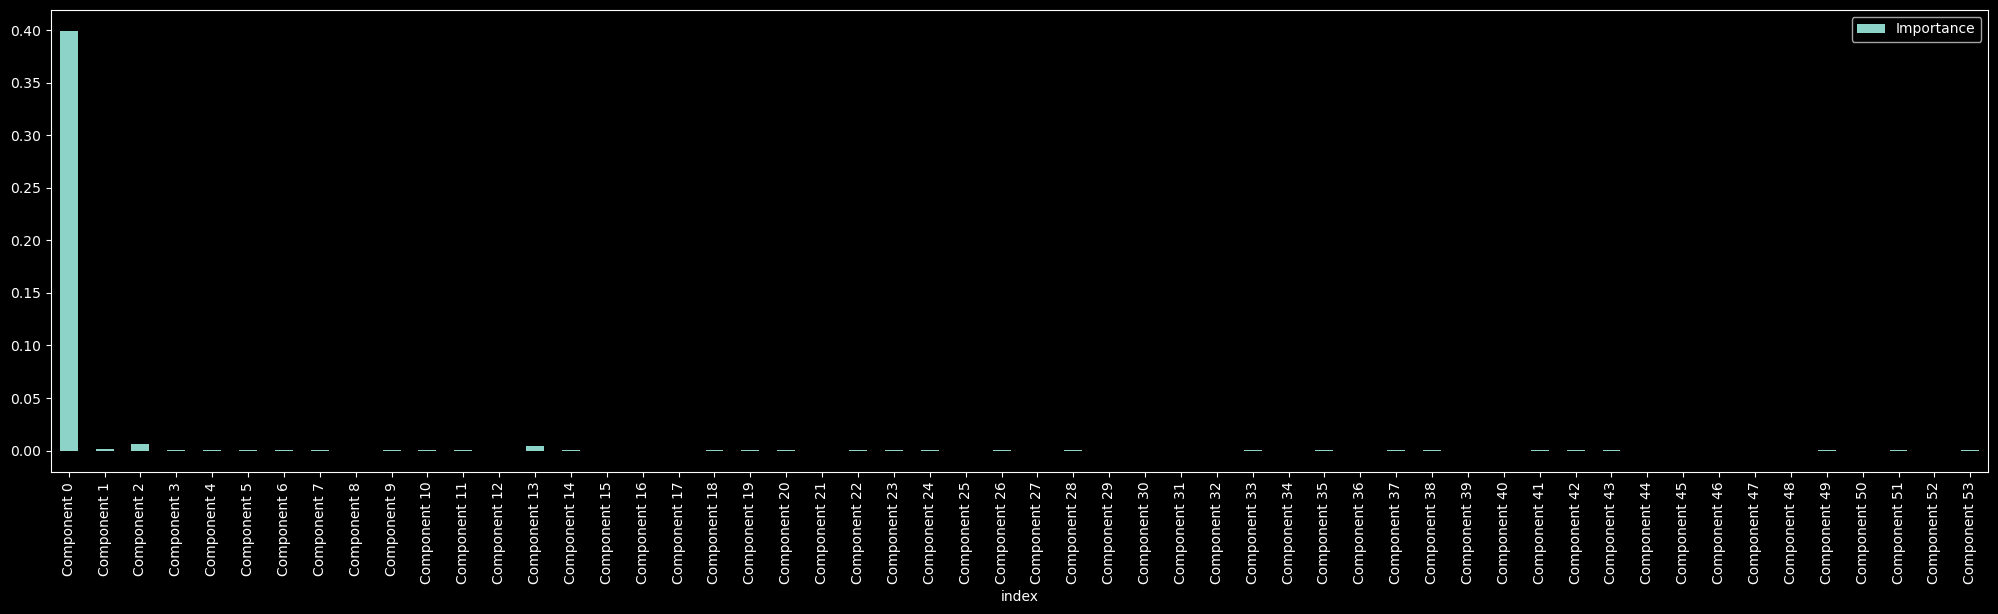

In [60]:
feature_imp_df=pd.DataFrame(
    index=X_tr_PCA.columns,
    data=feature_imp['importances_mean'],
    columns=['Importance']
).reset_index().plot.bar(x='index',y='Importance',figsize=(25,6))
plt.show()

Isto kako i prethodno, ochekuvano e component1 da imat najmnogu importance.